In [1]:
#import the necessary dependencies
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing

In [3]:
# Load dataset directory
data_dir = r'G:\projects\cricket shot detection\archive\data'


In [4]:
#lists the folders present in the given path
class_names = os.listdir(data_dir)
class_names

['drive', 'legglance-flick', 'pullshot', 'sweep']

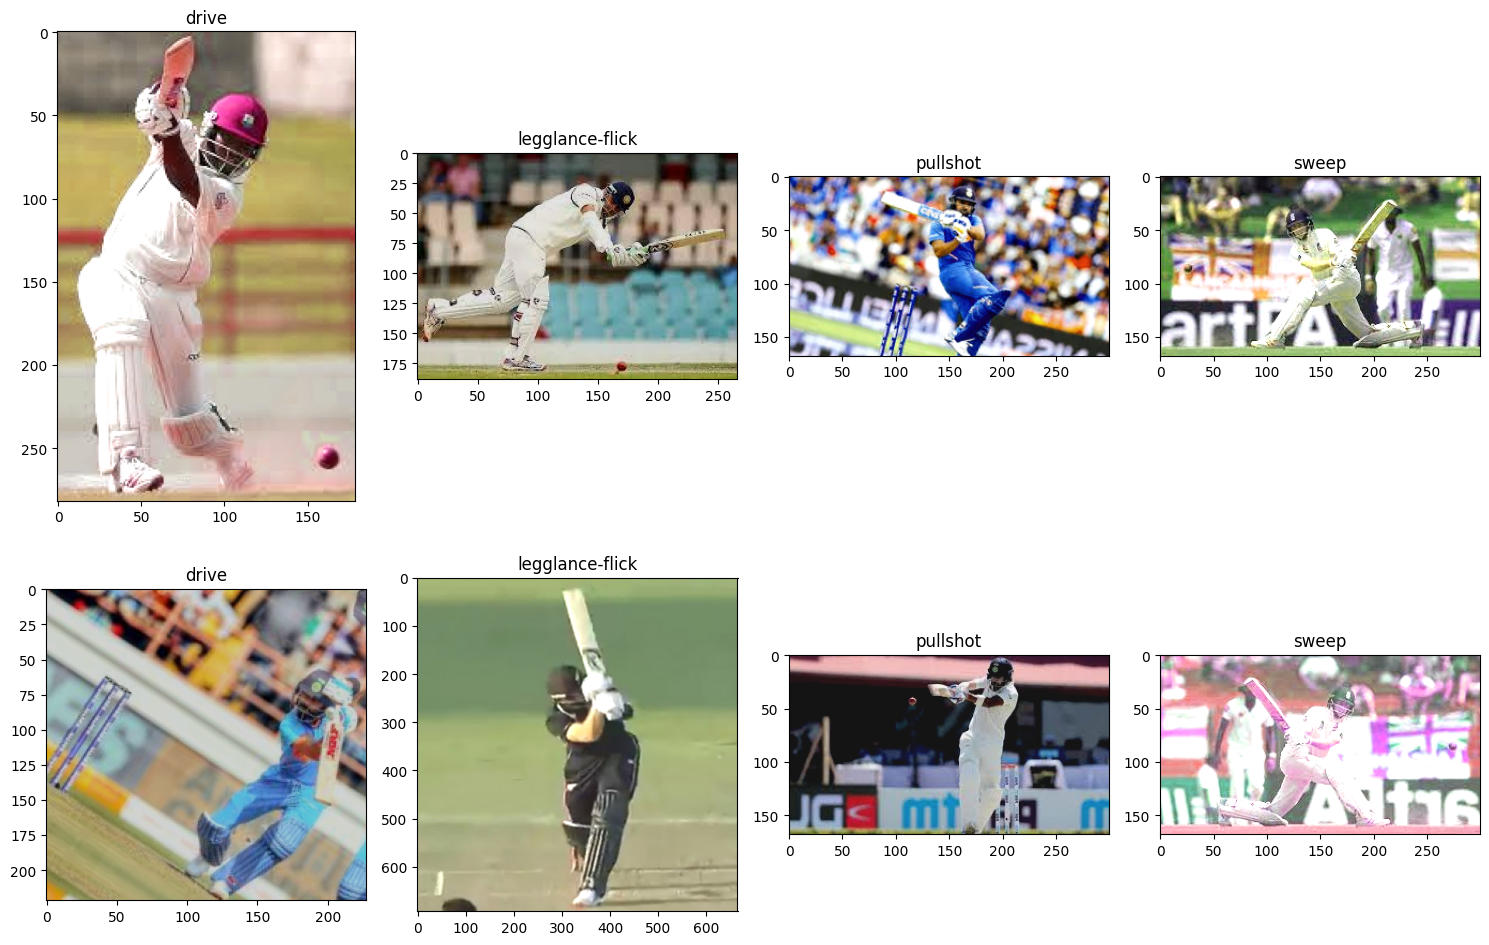

In [5]:
def visualize_images(image_paths: List[str]):
    max_rows = 2
    max_cols = 4
    fig, axs = plt.subplots(max_rows, max_cols, figsize=(15, 10))
    idx = 0
    for col in range(max_cols):
        for row in range(max_rows):
            if idx < len(image_paths):  # Check if idx is within bounds
                img = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                class_name = image_paths[idx].split(os.path.sep)[-2]  # Use os.path.sep for compatibility
                axs[row, col].imshow(image)
                axs[row, col].set_title(class_name)
            else:
                axs[row, col].axis('off')  # Hide unused subplots
            idx += 1
    plt.tight_layout()
    plt.show()

# Collect two random image paths from each class
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    all_images = glob(class_folder + '/*.png')
    if len(all_images) >= 2:  # Ensure there are at least 2 images in each class
        paths = random.sample(all_images, k=2)
        image_paths.extend(paths)

visualize_images(image_paths)


In [6]:
#creating a dataframe with image paths and labels
image_paths = []
class_labels = []
for class_name in class_names:
    paths = glob(os.path.join(data_dir, class_name) + '/' + "*.png")
    image_paths.extend(paths)
    class_labels.extend([class_name]*len(paths))
df = pd.DataFrame(data={'image_path': image_paths, 'label': class_labels})

In [7]:
print(df['label'].value_counts())

label
pullshot           1228
drive              1173
sweep              1100
legglance-flick    1085
Name: count, dtype: int64


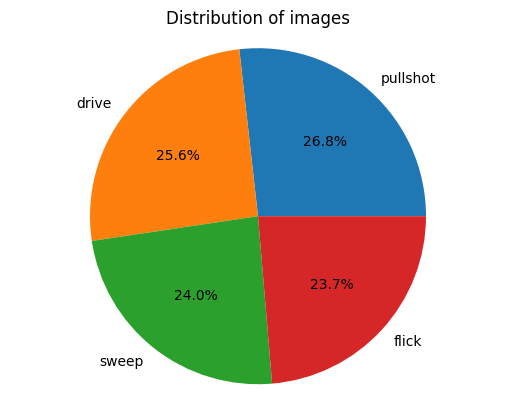

In [8]:
labels = 'pullshot', 'drive', 'sweep' , 'flick'
sizes = [1228, 1173, 1100, 1085]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title("Distribution of images")

plt.show()

In [9]:
X = df # Contains all columns.
y = df[['label']] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=0.30,
                                                          random_state=40)

    # Split the temp dataframe into val and test dataframes.

df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=0.5,
                                                      random_state=40)

In [10]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [11]:
# Set up image data generators
BATCH_SIZE = 32
IMG_SHAPE_2 = (224, 224, 3)
num_classes = 4

train_densenet = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_densenet = ImageDataGenerator()
test_densenet = ImageDataGenerator()

train_generator = train_densenet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)

valid_generator = val_densenet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

test_generator = test_densenet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [12]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

# Custom callback to log additional information after each epoch
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        dropout_rate = 0.3  # Defined dropout rate
        print(f"\nEpoch {epoch+1}:")
        print(f" - Accuracy: {logs.get('accuracy'):.4f}, Validation Accuracy: {logs.get('val_accuracy'):.4f}")
        print(f" - Loss: {logs.get('loss'):.4f}, Validation Loss: {logs.get('val_loss'):.4f}")
        print(f" - Current Learning Rate: {current_lr:.8f}")
        print(f" - Dropout Rate: {dropout_rate}")
        
        # Check early stopping condition
        if epoch >= early_stopping.start_from_epoch:
            print(" - Early Stopping Monitor Active")
        
        # Check if ReduceLROnPlateau condition was met
        if 'lr' in logs and logs['lr'] < current_lr:
            print(" - ReduceLROnPlateau Triggered: Learning rate reduced")

In [13]:
# Define and compile the model
model_ResNet = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE_2,
    weights='imagenet'
)
model_ResNet.trainable = False

# Adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_ResNet(input_layer, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_ResNet = tf.keras.Model(inputs=[input_layer], outputs=[output])

In [14]:
# Compile the model
model_ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Train the model with the custom logging callback
history_res = model_ResNet.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr, CustomLoggingCallback()],
    verbose=1
)


Epoch 1/10


101/101 [==============================] - ETA: 0s - loss: 17.4381 - accuracy: 0.6832
Epoch 1:
 - Accuracy: 0.6832, Validation Accuracy: 0.8721
 - Loss: 17.4381, Validation Loss: 0.3607
 - Current Learning Rate: 0.00100000
 - Dropout Rate: 0.3
101/101 [==============================] - 237s 2s/step - loss: 17.4381 - accuracy: 0.6832 - val_loss: 0.3607 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8928
Epoch 2:
 - Accuracy: 0.8928, Validation Accuracy: 0.9288
 - Loss: 0.2921, Validation Loss: 0.1816
 - Current Learning Rate: 0.00100000
 - Dropout Rate: 0.3
101/101 [==============================] - 226s 2s/step - loss: 0.2921 - accuracy: 0.8928 - val_loss: 0.1816 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9227
Epoch 3:
 - Accuracy: 0.9227, Validation Accuracy: 0.9302
 - Loss: 0.2181, Validation Loss: 0.1854
 - C

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot training results
plot_training(history_res)

In [43]:
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Define hyperparameters to iterate over
learning_rates = [0.0001]
batch_sizes = [16]
dropout_rates = [0.2, 0.3, 0.4]

# Store the results for each hyperparameter combination
results = []

# Prepare callback settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)

# Iterate over each combination of hyperparameters
for lr, batch_size, dropout_rate in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTesting combination: Learning rate={lr}, Batch size={batch_size}, Dropout={dropout_rate}")

    # Initialize the ResNet model for each combination to ensure fresh start
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze ResNet layers

    # Adding custom top layers
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    # Compile model with specified learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Track epochs to identify overfitting point
    early_stopping_triggered = False
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(1, 11):  # Run for a max of 10 epochs
        print(f"Epoch {epoch}/{10}")

        # Train the model for one epoch
        hist = model.fit(
            train_generator,
            epochs=1,
            validation_data=valid_generator,
            batch_size=batch_size,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Record accuracy and loss
        train_acc = hist.history['accuracy'][0]
        val_acc = hist.history['val_accuracy'][0]
        train_loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]

        # Append to history
        history['epoch'].append(epoch)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Check for overfitting condition
        if epoch > 2 and val_loss > history['val_loss'][-2] and not early_stopping_triggered:
            print(f"Overfitting detected at epoch {epoch}")
            early_stopping_triggered = True
            break

    # Store results for the current hyperparameter combination
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'epochs_run': len(history['epoch']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    })

# Print all results for each combination
print("\nResults Summary:")
for result in results:
    print(f"\nCombination: Learning Rate={result['learning_rate']}, Batch Size={result['batch_size']}, Dropout Rate={result['dropout_rate']}")
    print(f"  Epochs Run: {result['epochs_run']}")
    print(f"  Final Training Accuracy: {result['final_train_acc']:.4f}")
    print(f"  Final Validation Accuracy: {result['final_val_acc']:.4f}")
    print(f"  Final Training Loss: {result['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {result['final_val_loss']:.4f}")



Testing combination: Learning rate=0.0001, Batch size=16, Dropout=0.2
Epoch 1/10
101/101 [==============================] - 234s 2s/step - loss: 1.6706 - accuracy: 0.7474 - val_loss: 0.2836 - val_accuracy: 0.8910 - lr: 1.0000e-04
Epoch 2/10
101/101 [==============================] - 229s 2s/step - loss: 0.1847 - accuracy: 0.9340 - val_loss: 0.1941 - val_accuracy: 0.9259 - lr: 1.0000e-04
Epoch 3/10
101/101 [==============================] - 237s 2s/step - loss: 0.1292 - accuracy: 0.9548 - val_loss: 0.1130 - val_accuracy: 0.9535 - lr: 1.0000e-04
Epoch 4/10
101/101 [==============================] - 228s 2s/step - loss: 0.0715 - accuracy: 0.9748 - val_loss: 0.0687 - val_accuracy: 0.9767 - lr: 1.0000e-04
Epoch 5/10
101/101 [==============================] - 229s 2s/step - loss: 0.0545 - accuracy: 0.9807 - val_loss: 0.0782 - val_accuracy: 0.9724 - lr: 1.0000e-04
Overfitting detected at epoch 5

Testing combination: Learning rate=0.0001, Batch size=16, Dropout=0.3
Epoch 1/10
101/101 [======

In [44]:
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Define hyperparameters to iterate over
learning_rates = [0.001]
batch_sizes = [16]
dropout_rates = [0.2, 0.3, 0.4]

# Store the results for each hyperparameter combination
results = []

# Prepare callback settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)

# Iterate over each combination of hyperparameters
for lr, batch_size, dropout_rate in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTesting combination: Learning rate={lr}, Batch size={batch_size}, Dropout={dropout_rate}")

    # Initialize the ResNet model for each combination to ensure fresh start
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze ResNet layers

    # Adding custom top layers
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    # Compile model with specified learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Track epochs to identify overfitting point
    early_stopping_triggered = False
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(1, 11):  # Run for a max of 10 epochs
        print(f"Epoch {epoch}/{10}")

        # Train the model for one epoch
        hist = model.fit(
            train_generator,
            epochs=1,
            validation_data=valid_generator,
            batch_size=batch_size,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Record accuracy and loss
        train_acc = hist.history['accuracy'][0]
        val_acc = hist.history['val_accuracy'][0]
        train_loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]

        # Append to history
        history['epoch'].append(epoch)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Check for overfitting condition
        if epoch > 2 and val_loss > history['val_loss'][-2] and not early_stopping_triggered:
            print(f"Overfitting detected at epoch {epoch}")
            early_stopping_triggered = True
            break

    # Store results for the current hyperparameter combination
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'epochs_run': len(history['epoch']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    })

# Print all results for each combination
print("\nResults Summary:")
for result in results:
    print(f"\nCombination: Learning Rate={result['learning_rate']}, Batch Size={result['batch_size']}, Dropout Rate={result['dropout_rate']}")
    print(f"  Epochs Run: {result['epochs_run']}")
    print(f"  Final Training Accuracy: {result['final_train_acc']:.4f}")
    print(f"  Final Validation Accuracy: {result['final_val_acc']:.4f}")
    print(f"  Final Training Loss: {result['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {result['final_val_loss']:.4f}")



Testing combination: Learning rate=0.001, Batch size=16, Dropout=0.2
Epoch 1/10
101/101 [==============================] - 226s 2s/step - loss: 12.1499 - accuracy: 0.7065 - val_loss: 0.3177 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 238s 2s/step - loss: 0.2699 - accuracy: 0.9056 - val_loss: 0.2387 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 228s 2s/step - loss: 0.1651 - accuracy: 0.9430 - val_loss: 0.2374 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 4/10
101/101 [==============================] - 229s 2s/step - loss: 0.1527 - accuracy: 0.9492 - val_loss: 0.1499 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 5/10
101/101 [==============================] - 224s 2s/step - loss: 0.1047 - accuracy: 0.9654 - val_loss: 0.1066 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 6/10
101/101 [==============================] - 229s 2s/step - loss: 0.0787 - accuracy: 0.9707 - val_loss: 0.1652 - val_accuracy: 0.9549 - lr: 

In [16]:
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Define hyperparameters to iterate over
learning_rates = [0.01]
batch_sizes = [16]
dropout_rates = [0.2, 0.3, 0.4]

# Store the results for each hyperparameter combination
results = []

# Prepare callback settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)

# Iterate over each combination of hyperparameters
for lr, batch_size, dropout_rate in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTesting combination: Learning rate={lr}, Batch size={batch_size}, Dropout={dropout_rate}")

    # Initialize the ResNet model for each combination to ensure fresh start
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze ResNet layers

    # Adding custom top layers
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    # Compile model with specified learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Track epochs to identify overfitting point
    early_stopping_triggered = False
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(1, 11):  # Run for a max of 10 epochs
        print(f"Epoch {epoch}/{10}")

        # Train the model for one epoch
        hist = model.fit(
            train_generator,
            epochs=1,
            validation_data=valid_generator,
            batch_size=batch_size,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Record accuracy and loss
        train_acc = hist.history['accuracy'][0]
        val_acc = hist.history['val_accuracy'][0]
        train_loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]

        # Append to history
        history['epoch'].append(epoch)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Check for overfitting condition
        if epoch > 2 and val_loss > history['val_loss'][-2] and not early_stopping_triggered:
            print(f"Overfitting detected at epoch {epoch}")
            early_stopping_triggered = True
            break

    # Store results for the current hyperparameter combination
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'epochs_run': len(history['epoch']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    })

# Print all results for each combination
print("\nResults Summary:")
for result in results:
    print(f"\nCombination: Learning Rate={result['learning_rate']}, Batch Size={result['batch_size']}, Dropout Rate={result['dropout_rate']}")
    print(f"  Epochs Run: {result['epochs_run']}")
    print(f"  Final Training Accuracy: {result['final_train_acc']:.4f}")
    print(f"  Final Validation Accuracy: {result['final_val_acc']:.4f}")
    print(f"  Final Training Loss: {result['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {result['final_val_loss']:.4f}")



Testing combination: Learning rate=0.01, Batch size=16, Dropout=0.2
Epoch 1/10
101/101 [==============================] - 259s 3s/step - loss: 135.9900 - accuracy: 0.5140 - val_loss: 1.1063 - val_accuracy: 0.5131 - lr: 0.0100
Epoch 2/10
101/101 [==============================] - 252s 2s/step - loss: 1.5698 - accuracy: 0.6240 - val_loss: 0.8262 - val_accuracy: 0.6366 - lr: 0.0100
Epoch 3/10
101/101 [==============================] - 258s 3s/step - loss: 1.9124 - accuracy: 0.6785 - val_loss: 1.6342 - val_accuracy: 0.6817 - lr: 0.0100
Overfitting detected at epoch 3

Testing combination: Learning rate=0.01, Batch size=16, Dropout=0.3
Epoch 1/10
101/101 [==============================] - 258s 3s/step - loss: 105.6979 - accuracy: 0.6034 - val_loss: 1.2041 - val_accuracy: 0.7035 - lr: 0.0100
Epoch 2/10
101/101 [==============================] - 253s 3s/step - loss: 1.1518 - accuracy: 0.7087 - val_loss: 1.4149 - val_accuracy: 0.7660 - lr: 0.0100
Epoch 3/10
101/101 [==========================